Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D



In [5]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
#!pwd
data_dir_train = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Data/Train')
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Data/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [16]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [17]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


In [18]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


In [19]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

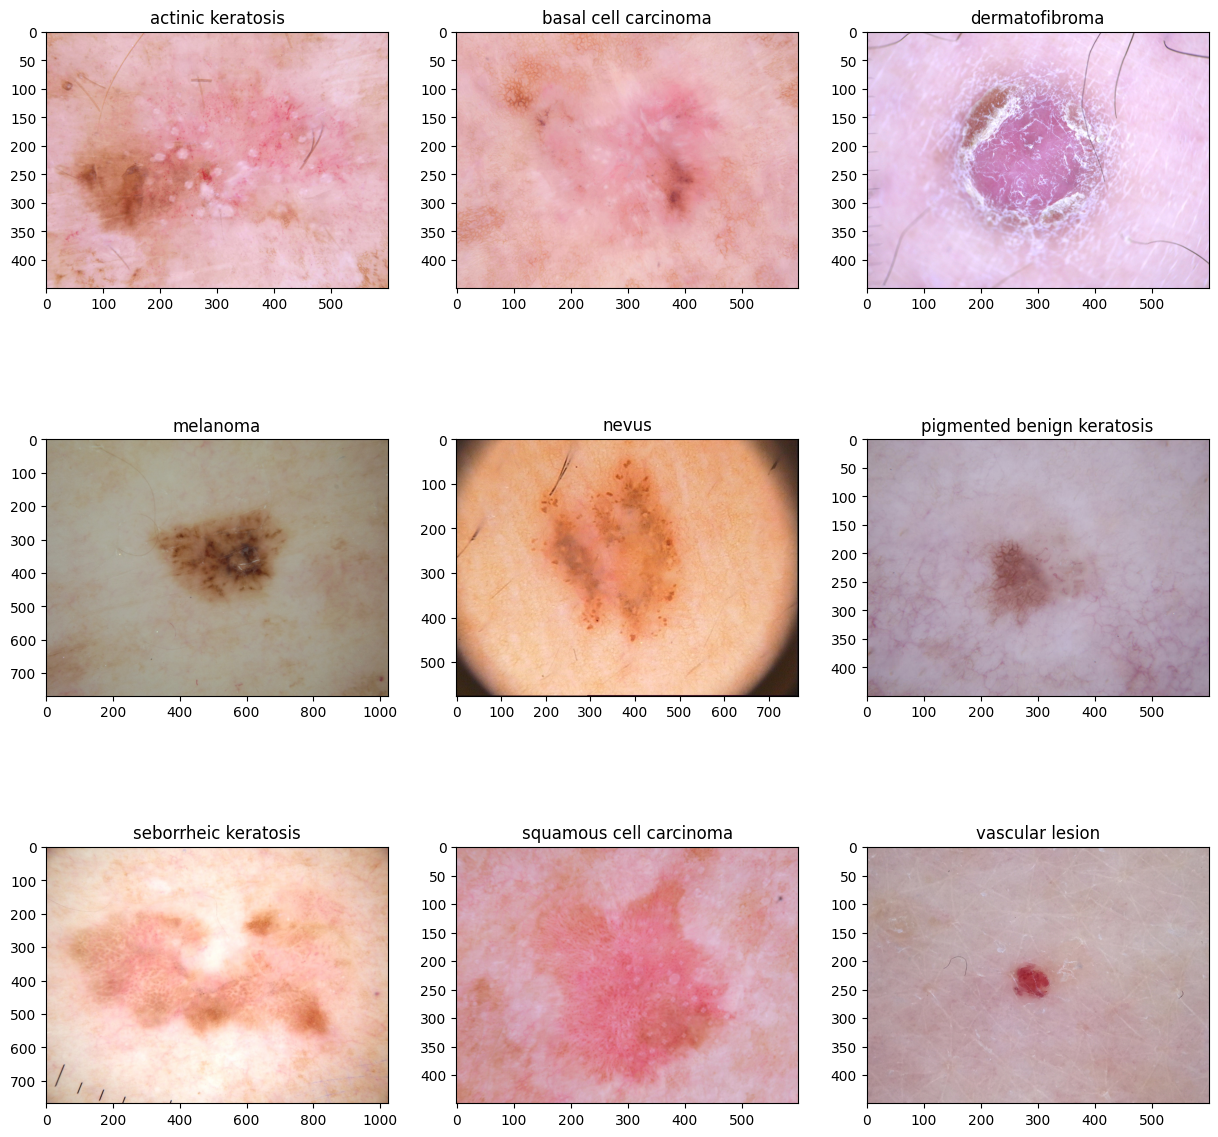

In [10]:
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
#First Convulation layer
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#2nd Convulation layer
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#3rd Convulation layer
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input
model.add(Dropout(0.25))

#Flatten Layer
model.add(Flatten())

#Dense Layer with softmax activation function
model.add(Dense(num_classes, activation = "softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
#Adam optimization: stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
#earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)


In [13]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

### Train the model

In [15]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


281/281 [==============================] - 1627s 1s/step - loss: 1.7518 - accuracy: 0.3222 - val_loss: 1.5492 - val_accuracy: 0.3943
Epoch 2/20
281/281 [==============================] - 25s 90ms/step - loss: 1.5260 - accuracy: 0.4073 - val_loss: 1.5159 - val_accuracy: 0.4223
Epoch 3/20
281/281 [==============================] - 25s 91ms/step - loss: 1.3089 - accuracy: 0.4917 - val_loss: 1.2781 - val_accuracy: 0.5131
Epoch 4/20
281/281 [==============================] - 25s 90ms/step - loss: 1.1640 - accuracy: 0.5586 - val_loss: 1.2136 - val_accuracy: 0.5381
Epoch 5/20
281/281 [==============================] - 27s 95ms/step - loss: 1.0039 - accuracy: 0.6220 - val_loss: 0.9410 - val_accuracy: 0.6604
Epoch 6/20
281/281 [==============================] - 25s 89ms/step - loss: 0.8959 - accuracy: 0.6657 - val_loss: 0.8987 - val_accuracy: 0.6609
Epoch 7/20
281/281 [==============================] - 25s 89ms/step - loss: 0.7941 - accuracy: 0.7097 - val_loss: 0.8214 - val_accuracy: 0.7089
Epo

### Visualizing training results

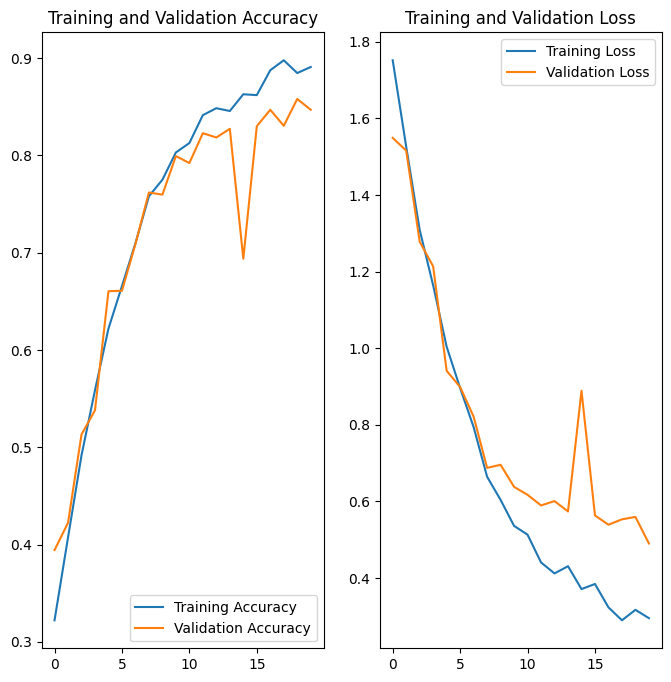

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inference:**

Vaildation Accuracy: ~ 50-60% due to engough features to remember the pattern. Neural Network is based on 20 epochs so learning is just started

Initial Findings: Model is overfitting compare to loss function. Loss Function between training and validation around 19-20th epoch

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])


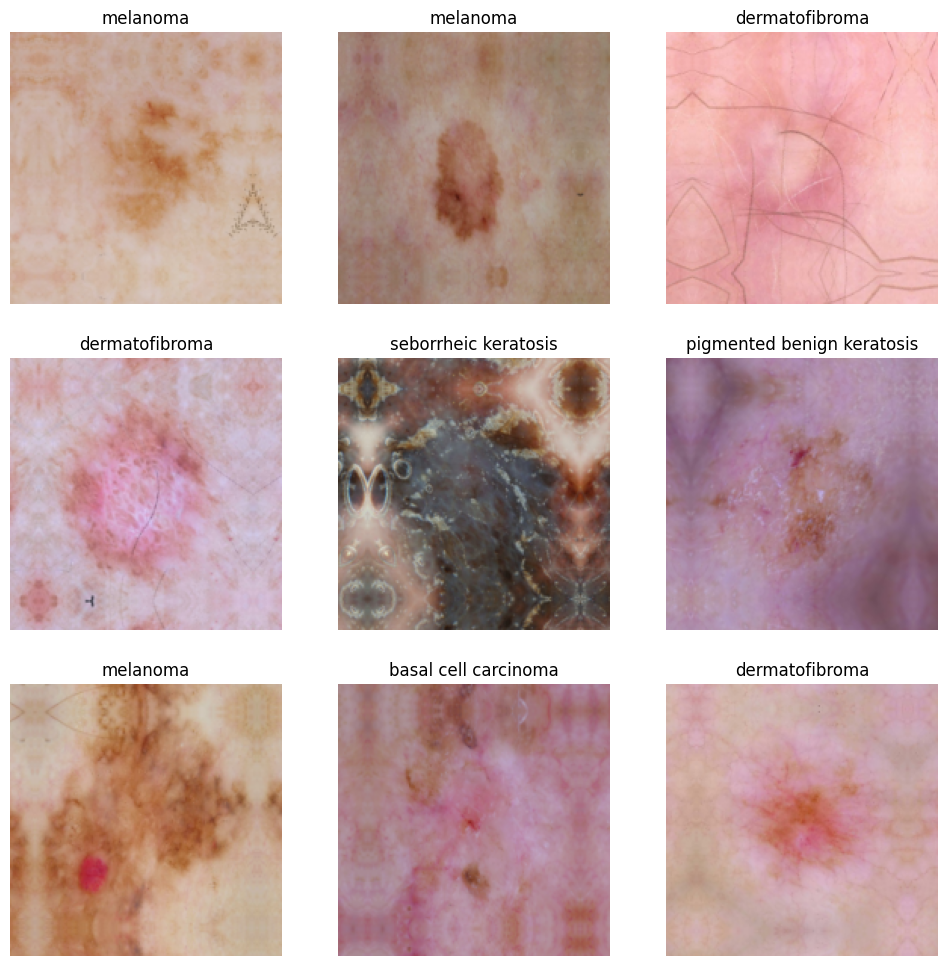

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
281/281 [==============================] - 28s 95ms/step - loss: 2.1980 - accuracy: 0.1263 - val_loss: 2.1935 - val_accuracy: 0.1282
Epoch 2/20
281/281 [==============================] - 25s 89ms/step - loss: 2.1924 - accuracy: 0.1233 - val_loss: 2.1912 - val_accuracy: 0.1331
Epoch 3/20
281/281 [==============================] - 26s 92ms/step - loss: 2.1912 - accuracy: 0.1293 - val_loss: 2.1905 - val_accuracy: 0.1331
Epoch 4/20
281/281 [==============================] - 25s 88ms/step - loss: 2.1908 - accuracy: 0.1293 - val_loss: 2.1902 - val_accuracy: 0.1331
Epoch 5/20
281/281 [==============================] - 25s 88ms/step - loss: 2.1907 - accuracy: 0.1259 - val_loss: 2.1901 - val_accuracy: 0.1282
Epoch 6/20
281/281 [==============================] - 26s 91ms/step - loss: 2.1906 - accuracy: 0.1272 - val_loss: 2.1901 - val_accuracy: 0.1331
Epoch 7/20
281/281 [==============================] - 26s 92ms/step - loss: 2.1906 - accuracy: 0.1273 - val_loss: 2.1900 - val_accuracy:

### Visualizing the results

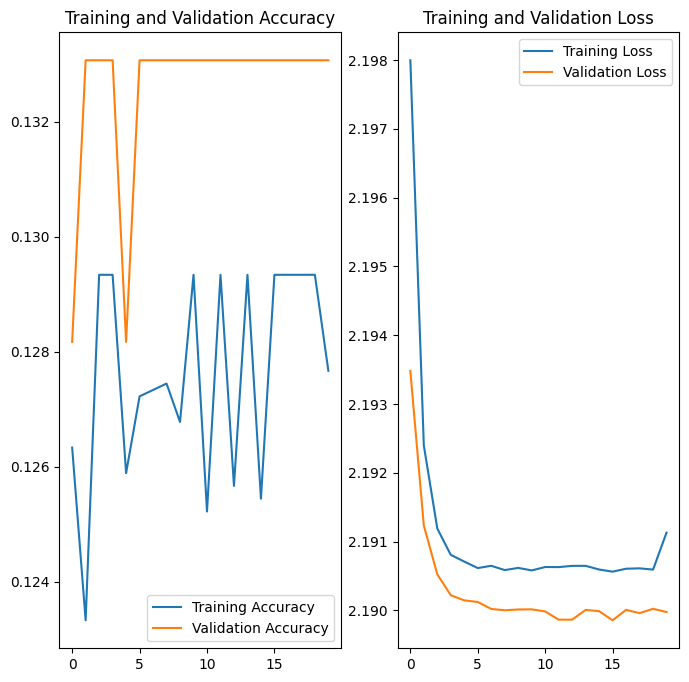

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inference:**
*   Overfitting issue has been addressed due to data augmentation
*   However model is trained on 20 epochs, which don't infer proper conclusion



#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
def class_distribution_count(directory):

    cnt= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            cnt.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    return pd.DataFrame(list(zip(sub_directory,cnt)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

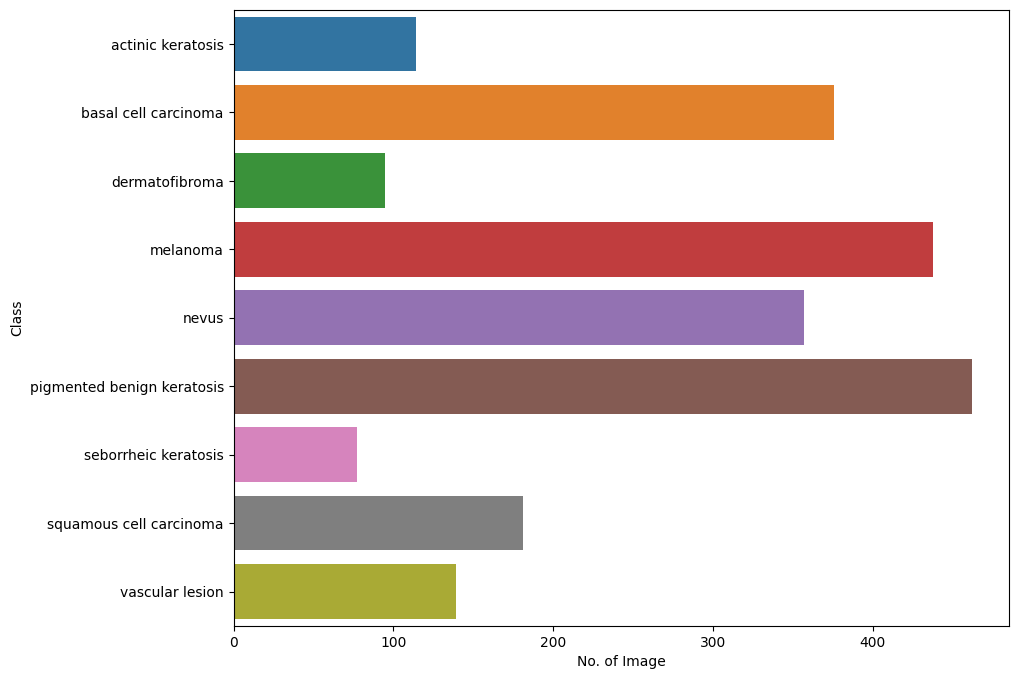

In [24]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Finding:**  
#### - seborrheic keratosis class has the least number of samples
#### - pigmented benign keratosis classes having the highest proportionate in terms number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
from pathlib import Path
ds_dir=pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Data/')
path_to_training_dataset=os.path.join(ds_dir, ('Train/'))
#path_to_training_dataset = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Data/Train')
import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D98E06DF7F0>: 100%|██████████| 500/500 [00:20<00:00, 24.06 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D98E06F7CA0>: 100%|██████████| 500/500 [00:23<00:00, 21.71 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9938167A30>: 100%|██████████| 500/500 [00:24<00:00, 20.60 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D98E067FF70>: 100%|██████████| 500/500 [01:32<00:00,  5.43 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7D98E0582F80>: 100%|██████████| 500/500 [01:25<00:00,  5.86 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D98E0599F30>: 100%|██████████| 500/500 [00:18<00:00, 27.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D98E6036890>: 100%|██████████| 500/500 [00:40<00:00, 12.44 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D998CEF38B0>: 100%|██████████| 500/500 [00:18<00:00, 26.98 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9971380640>: 100%|██████████| 500/500 [00:22<00:00, 22.63 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Colab Notebooks/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_67d4ffb0-ce95-4898-811e-c1553c3c5d7f.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_a9a572bf-5695-4ebf-a475-cecd9659701f.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_a37f90f6-3679-438d-a206-ba13834be505.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_3eb8e25e-e587-4bdf-a306-e6abd7b3e680.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027536.jpg_460f6395-aa4b-4fca-9088-83081f1bfc08.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025825.jpg_575a1fa1-a9e0-49a1-9b61-487dcfa5dc17.jpg',
 '/c

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [30]:
#dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

NameError: ignored

In [ ]:
#df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [ ]:
#new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [1]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [7]:
ds_dir=pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Data/')
path_to_training_dataset=os.path.join(ds_dir, ('Train/'))
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_training_dataset,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


#### **Todo:** Create a validation dataset

In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [20]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 41, 41, 128)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [21]:
model.compile(optimizer='adam',
              #loss='categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
#from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )